# Making some figures on paper

In this notebook, we reproduce the Figure 1 in the paper. We use only the CSV file.

## Imports

### Pythons Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator


### Personal Code

In [35]:
from diagnostic_diagrams_plots import diagnostic_diagram_plot
from misc import kewley
from utils_plot import textonly, textonly2

## Some useful functions

### Reading data function

In [3]:
def read_csv(file_path):
    if not os.path.isfile(file_path):
        print("File csv does not exists: {}".format(file_path))
        return None
    try:
        with open(file_path, "r") as file_input:
            lines = []
            for line in file_input:
                if line.startswith("#  COLUMN"):
                    lines.append(line.split()[2])
        table_df = pd.read_csv(file_path, comment='#', header=None)
        table_df.columns = lines
        table_df.set_index(lines[0], inplace=True)
    except:
        print('Something is wrong with csv file: {}'.format(file_path))
        return None
    return table_df

### Plotting functions

In [30]:
def plot_diagnostic_diagram_single(type_plot: str, statistic: str,
                                   prop: str,
                                   data: pd.DataFrame,
                                   ax: plt.Axes,
                                   vmin=None, vmax=None,
                                   histogram=False) -> mpl.image.AxesImage:
    """
    Diagnostic diagrams plotting auxiliary function
    """
    ylabel = 'O3Hb_dd'
    if type_plot == 'O3N2':
        xlabel = 'N2Ha_dd'
    elif type_plot == 'O3S2':
        xlabel = 'S2Ha_dd'
    elif type_plot == 'O3O1':
        xlabel = 'O1Ha_dd'
    elif type_plot == 'O3O2':
        xlabel = 'O2Hb_dd'
    x_data = np.log10(data[xlabel])
    y_data = np.log10(data[ylabel])
    z_data = data[prop]
    mean_prop = np.mean(z_data)
    std_prop = np.std(z_data)
    # print(prop, mean_prop, std_prop)
    if statistic == 'mean':
        if vmin is None:
            if prop == 'Av':
                vmin = 0
            else:
                vmin = mean_prop - 3*std_prop
        if vmax is None:
            if prop == 'Av':
                vmax = 2*mean_prop
            else:
                vmax = mean_prop + 3*std_prop
    elif statistic == 'std':
        if vmin is None:
            vmin = 0
        if vmax is None:
            vmax = 2*std_prop
    plot = diagnostic_diagram_plot(x_data, y_data, z_data, type_plot=type_plot,
                                   vmin=vmin, vmax=vmax, ax=ax,
                                   statistic=statistic)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(axis='both', which='both', direction='in', top=True,
                   right=True)
    if histogram:
        axis_ins = ax.inset_axes([0.05, 0.05, 0.35, 0.35])
        counts, bins, _ = axis_ins.hist(z_data, bins=60, density=True,
                                        range=(vmin, vmax), color='k')
        axis_ins.plot([mean_prop, mean_prop], [0, max(counts)], 'r--', lw=1)
        msg = r"${}\pm{}$".format(np.round(mean_prop, 2),
                                  np.round(std_prop, 2))
        if prop == 'f_y':
            y_pos = mean_prop+.05
        else:
            y_pos = mean_prop+.15
        axis_ins.text(y_pos, max(counts)*(0.9), msg, {'fontsize': 8})
        axis_ins.spines['top'].set_visible(False)
        axis_ins.spines['right'].set_visible(False)
        axis_ins.spines['left'].set_visible(False)
        axis_ins.set_yticks([])
        axis_ins.set_xticklabels([])
        axis_ins.set_xticks(get_ticks_hist(prop))
    return plot


### Filter functions

Clean data for diagnostic diagrams

In [5]:
def clean_data_diagnostic_diagrams(data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean data function
    """
    mask_o3hb = (data['O3Hb_dd'] > 0) & (np.isfinite(data['O3Hb_dd']))
    mask_n2ha = (data['N2Ha_dd'] > 0) & (np.isfinite(data['N2Ha_dd']))
    mask_s2ha = (data['S2Ha_dd'] > 0) & (np.isfinite(data['S2Ha_dd']))
    mask_o1ha = (data['O1Ha_dd'] > 0) & (np.isfinite(data['O1Ha_dd']))
    mask_o2hb = (data['O2Hb_dd'] > 0) & (np.isfinite(data['O2Hb_dd']))
    mask = mask_o3hb & mask_n2ha & mask_s2ha & mask_o1ha & mask_o2hb
    return data[mask]



Clean by Kewley line

In [6]:
def clean_kewley_line(data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean data function by kewley line
    """
    logN2Ha = np.log10(data['N2Ha_dd'])
    O3Hb_kewley = kewley(logN2Ha) + 0.1*kewley(logN2Ha)
    mask = np.log10(data['O3Hb_dd']) < O3Hb_kewley
    return data[mask]

Clean bby physical properties

In [7]:
def clean_data_physical_properties(data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean data by physical properties
    """
    labels = ['f_y', 'EW', 'U_Mor16_O23_ts', 'OH_Ho', 'NO_Pil16_Ho_R',
              'Ne_Oster_S', 'Av', 'U_Mor16_O23_fs']
    mask = np.isfinite(data[labels[0]])
    masks = {label: np.isfinite(data[label]) for label in labels[1:]}
    for _, item in masks.items():
        mask = np.logical_and(mask, item)
    return data[mask]


In [8]:
def main_clean_function(data: pd.DataFrame) -> pd.DataFrame:
    data = clean_data_diagnostic_diagrams(data)
    data = clean_kewley_line(data)
    data = clean_data_physical_properties(data)
    return data

### Aesthetic functions

In [9]:
def get_ticks_hist(prop: str):
    if prop.startswith('f_y'):
        ticks = np.arange(0, 0.9, 0.2)
    elif prop.startswith('U'):
        ticks = np.arange(-4, -2.4, 0.5)
    elif prop.startswith('OH'):
        ticks = np.arange(8, 9.3, 0.4)
    elif prop.startswith('NO'):
        ticks = np.arange(-1.6, -0.3, 0.4)
    elif prop.startswith('Ne'):
        ticks = np.arange(1, 4.1, 1)
    elif prop.startswith('Av'):
        ticks = np.arange(0, 2.1, 0.5)
    return ticks


## Reading data

In [13]:
data = read_csv('/home/espinosa/data/CALIFA_DATA/main_table.csv')

In [14]:
data

,f_y,dist,EW,Av,OII3727_cor,H123750_cor,H113771_cor,H103798_cor,HeI3819_cor,H93835_cor,...,euq_IZI_J_byler_CSFR,edq_IZI_mean_byler_CSFR,euq_IZI_mean_byler_CSFR,edq_IZI_max_byler_CSFR,euq_IZI_max_byler_CSFR,eNH_Pil16_R,eNO_HCm_no_interp,eNO_HCm_interp,eNO_Pil16_Ho_R,eNe_Oster_S
HIIREGID,,,,,,,,,,,,,,,,,,,,,
2MASSXJ22532475-1,0.137743,0.142824,1.309602,0.776740,94.304764,2.991211,-6.538717,-0.461934,3.377775,-5.125580,...,0.181818,0.139322,0.224314,0.121212,0.242424,0.014428,0.36,0.36,0.009567,0.055842
2MASSXJ22532475-2,0.109211,0.083157,0.932996,1.263837,210.043841,-6.493260,-8.249700,-3.191733,-7.220607,-1.318009,...,0.242424,0.147770,0.185564,0.181818,0.151515,0.022219,0.37,0.37,0.015177,0.201480
2MASSXJ22532475-3,0.233925,0.265309,1.320867,0.754034,77.383049,-2.211062,-4.216946,-4.091756,7.959131,1.888979,...,0.151515,0.129884,0.233752,0.121212,0.242424,0.018023,0.37,0.37,0.012752,0.507840
2MASSXJ22532475-4,0.211827,0.280490,1.262609,0.637651,41.574411,-6.572414,-2.802544,4.466805,-0.774214,-3.215268,...,0.272727,0.145675,0.217962,0.151515,0.212121,0.023110,0.37,0.37,0.015899,0.393606
2MASSXJ22532475-5,0.261642,0.281465,1.118353,0.655894,22.225174,-0.144241,0.700954,3.836635,-3.778939,-3.471482,...,0.272727,0.148088,0.185245,0.181818,0.151515,0.046531,0.31,0.31,0.029774,0.122235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UGC07993-14,0.156814,NaN,1.402807,3.036369,985.807905,50.719027,-136.286857,78.783194,19.980578,-19.134435,...,0.242424,0.129861,0.203472,0.151515,0.181818,0.035753,0.07,0.06,0.028295,0.081337
UGC07993-17,0.435114,NaN,1.203395,1.129314,95.768835,11.435800,0.290751,0.222148,-5.140972,-5.437169,...,0.212121,0.120826,0.212508,0.181818,0.151515,0.026827,0.04,0.05,0.017249,0.046182
UGC07993-22,0.221005,NaN,0.852251,3.073277,853.560368,101.846781,-159.583315,37.997989,0.990057,-49.149452,...,0.212121,0.125620,0.207713,0.181818,0.151515,0.059362,0.05,0.03,0.063102,0.067043


## Making a single BPT diagram

### Defining line ratios

In [15]:
data['O3Hb_dd'] = data['OIII5006_cor'] / data['Hb4861_cor']
data['N2Ha_dd'] = data['NII6583_cor'] / data['Ha6562_cor']
data['S2Ha_dd'] = (data['SII6716_cor'] + data['SII6730_cor']) / data['Ha6562_cor']
data['O1Ha_dd'] = data['OI6300_cor'] / data['Ha6562_cor']
data['O2Hb_dd'] = data['OII3727_cor'] / data['Hb4861_cor']


### Plotting

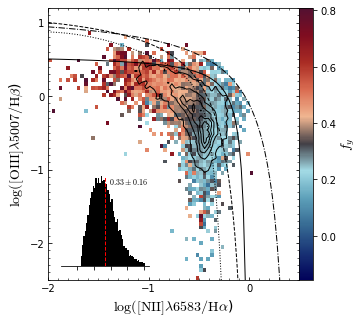

In [34]:
fig, ax = plt.subplots(figsize=(5.3, 5))
ylabel = r'$\log([\mathrm{OIII}]\lambda 5007/\mathrm{H}\beta$)'
xlabel = r'$\log([\mathrm{NII}]\lambda 6583/\mathrm{H}\alpha$)'
plot = plot_diagnostic_diagram_single('O3N2', 'mean', 'f_y', main_clean_function(data), ax, histogram=True)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
colorbar = fig.colorbar(plot, ax=ax, pad=0)
colorbar.set_label(r'$f_y$')
colorbar.set_ticks(np.arange(0, 0.9, 0.2))


## Making the Figure 1

### Function

In [41]:
def plot_diagnostic_diagram(type_plot: str, statistic: str,
                            data: pd.DataFrame, vmin=None, vmax=None,
                            histogram=False) -> None:
    """
    Diagnostic diagrams plotting function
    """
    ylabel = r'$\log([\mathrm{OIII}]\lambda 5007/\mathrm{H}\beta$)'
    if type_plot == 'O3N2':
        xlabel = r'$\log([\mathrm{NII}]\lambda 6583/\mathrm{H}\alpha$)'
    elif type_plot == 'O3S2':
        xlabel = r'$\log([\mathrm{SII}]\lambda 6716+30/\mathrm{H}\alpha$)'
    elif type_plot == 'O3O1':
        xlabel = r'$\log([\mathrm{OI}]\lambda 6300/\mathrm{H}\alpha$)'
    elif type_plot == 'O3O2':
        xlabel = r'$\log([\mathrm{OII}]\lambda 3726+29/\mathrm{H}\beta)$'
    if statistic == 'mean':
        fig, axes = plt.subplots(3, 2, figsize=(
            12.2, 14), sharex=True, sharey=True)
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='f_y', data=data, ax=axes[0][0],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[0][0], pad=0)
        # colorbar.set_label(r'$f_y$')
        colorbar.set_ticks(np.arange(0, 0.9, 0.2))
        textonly(axes[0][0], r'$f_y$', 12, 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=-4, vmax=-2.3,
                                        prop='U_Mor16_O23_ts',
                                        data=data, ax=axes[0][1],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[0][1], pad=0)
        colorbar.set_ticks(np.arange(-4, -2.4, 0.5))
        # colorbar.set_label(r'$\log(\mathrm{U})$')
        textonly(axes[0][1], r'$\log(\mathrm{U})$', 12,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=7.6, vmax=9,
                                        prop='OH_Ho',
                                        # prop='OH_M13_O3N2',
                                        data=data, ax=axes[1][0],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[1][0], pad=0)
        # colorbar.set_label(r'$12 + \log(\mathrm{O}/\mathrm{H})$')
        colorbar.set_ticks(np.arange(8, 9.3, 0.4))
        textonly(axes[1][0], r'$12 + \log(\mathrm{O}/\mathrm{H})$', 12,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=-1.5, vmax=-0.5,
                                        prop='NO_Pil16_Ho_R',
                                        data=data, ax=axes[1][1],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[1][1], pad=0)
        colorbar.set_ticks(np.arange(-1.6, -0.3, 0.4))
        # colorbar.set_label(r'$\log(\mathrm{N}/\mathrm{O})$')
        textonly(axes[1][1], r'$\log(\mathrm{N}/\mathrm{O})$', 12,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=2, vmax=4,
                                        prop='Ne_Oster_S',
                                        data=data, ax=axes[2][1],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[2][1], pad=0)
        colorbar.set_ticks(np.arange(1, 4.1, 1))
        # colorbar.set_label(r'$\log(n_e)$')
        textonly(axes[2][1], r'$\log(n_e)$', 12,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=3.2,
                                        prop='Av',
                                        data=data, ax=axes[2][0],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[2][0], pad=0)
        colorbar.set_ticks(np.arange(-1, 3.1, 0.5))
        # colorbar.set_label(r'$\mathrm{A}v$')
        textonly(axes[2][0], r'$\mathrm{A}v$', 12,
                 'lower right', 'normal')
    if statistic == 'std':
        fig, axes = plt.subplots(3, 2, figsize=(
            6.1, 7), sharex=True, sharey=True)
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='f_y', data=data, ax=axes[0][0],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[0][0], pad=0)
        # colorbar.set_label(r'$f_y$')
        textonly(axes[0][0], r'$f_y$', 14, 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='U_Mor16_O23_ts',
                                        data=data, ax=axes[0][1],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[0][1], pad=0)
        # colorbar.set_label(r'$\log(\mathrm{U})$')
        textonly(axes[0][1], r'$\log(\mathrm{U})$', 14,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='OH_Ho',
                                        data=data, ax=axes[1][0],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[1][0], pad=0)
        # colorbar.set_label(r'$12 + \log(\mathrm{O}/\mathrm{H})$')
        textonly(axes[1][0], r'$12 + \log(\mathrm{O}/\mathrm{H})$', 14,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='NO_Pil16_Ho_R',
                                        data=data, ax=axes[1][1],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[1][1], pad=0)
        # colorbar.set_label(r'$\log(\mathrm{N}/\mathrm{O})$')
        textonly(axes[1][1], r'$\log(\mathrm{N}/\mathrm{O})$', 14,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='Ne_Oster_S',
                                        data=data, ax=axes[2][1],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[2][1], pad=0)
        # colorbar.set_label(r'$\log(n_e)$')
        textonly(axes[2][1], r'$\log(n_e)$', 14,
                 'lower right', 'normal')
        plot = plot_diagnostic_diagram_single(type_plot, statistic,
                                        # vmin=0, vmax=1,
                                        prop='Av',
                                        data=data, ax=axes[2][0],
                                        histogram=histogram)
        colorbar = fig.colorbar(plot, ax=axes[2][0], pad=0)
        # colorbar.set_label(r'$\mathrm{A}v$')
        textonly(axes[2][0], r'$\mathrm{A}v$', 14,
                 'lower right', 'normal')
    fig.text(0.01, 0.57, ylabel, fontsize=12,
             va='center', rotation='vertical')
    fig.text(0.5, 0.04, xlabel, ha='center')
    fig.subplots_adjust(left=0.1, right=0.950, top=0.99, bottom=0.1,
                        hspace=0.027, wspace=0.15)


### Plotting

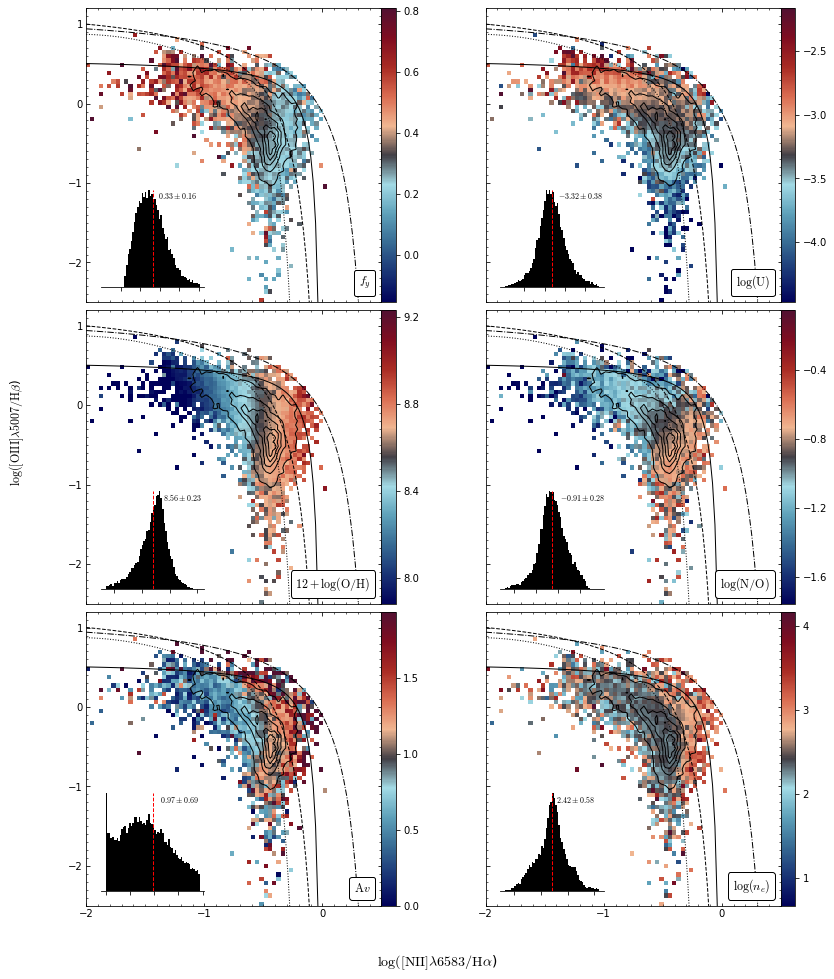

In [42]:
plot_diagnostic_diagram('O3N2', 'mean', main_clean_function(data), histogram=True)
